In [1]:
# data processing, CSV & image file I/O
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

#libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# import Deep learning Libraries
#preprocessing, modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

2024-05-05 09:07:51.314323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 09:07:51.314423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 09:07:51.435987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir= '/kaggle/input/animal-data/animal_data'
filepaths=[]
labels=[]


folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        # Select just tumor name
        fold = str(fold).replace('C+', '')
        labels.append(fold[:-3])

        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
df

filepaths labels
0     /kaggle/input/animal-data/animal_data/Horse/Ho...     Ho
1     /kaggle/input/animal-data/animal_data/Horse/Ho...     Ho
2     /kaggle/input/animal-data/animal_data/Horse/Ho...     Ho
3     /kaggle/input/animal-data/animal_data/Horse/Ho...     Ho
4     /kaggle/input/animal-data/animal_data/Horse/Ho...     Ho
...                                                 ...    ...
1939  /kaggle/input/animal-data/animal_data/Deer/Dee...      D
1940  /kaggle/input/animal-data/animal_data/Deer/Dee...      D
1941  /kaggle/input/animal-data/animal_data/Deer/Dee...      D
1942  /kaggle/input/animal-data/animal_data/Deer/Dee...      D
1943  /kaggle/input/animal-data/animal_data/Deer/Dee...      D

[1944 rows x 2 columns]

In [4]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [5]:
# crobed image size
batch_size = 16
img_size = (300, 300)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 1555 validated image filenames belonging to 12 classes.
Found 233 validated image filenames belonging to 12 classes.
Found 156 validated image filenames belonging to 12 classes.


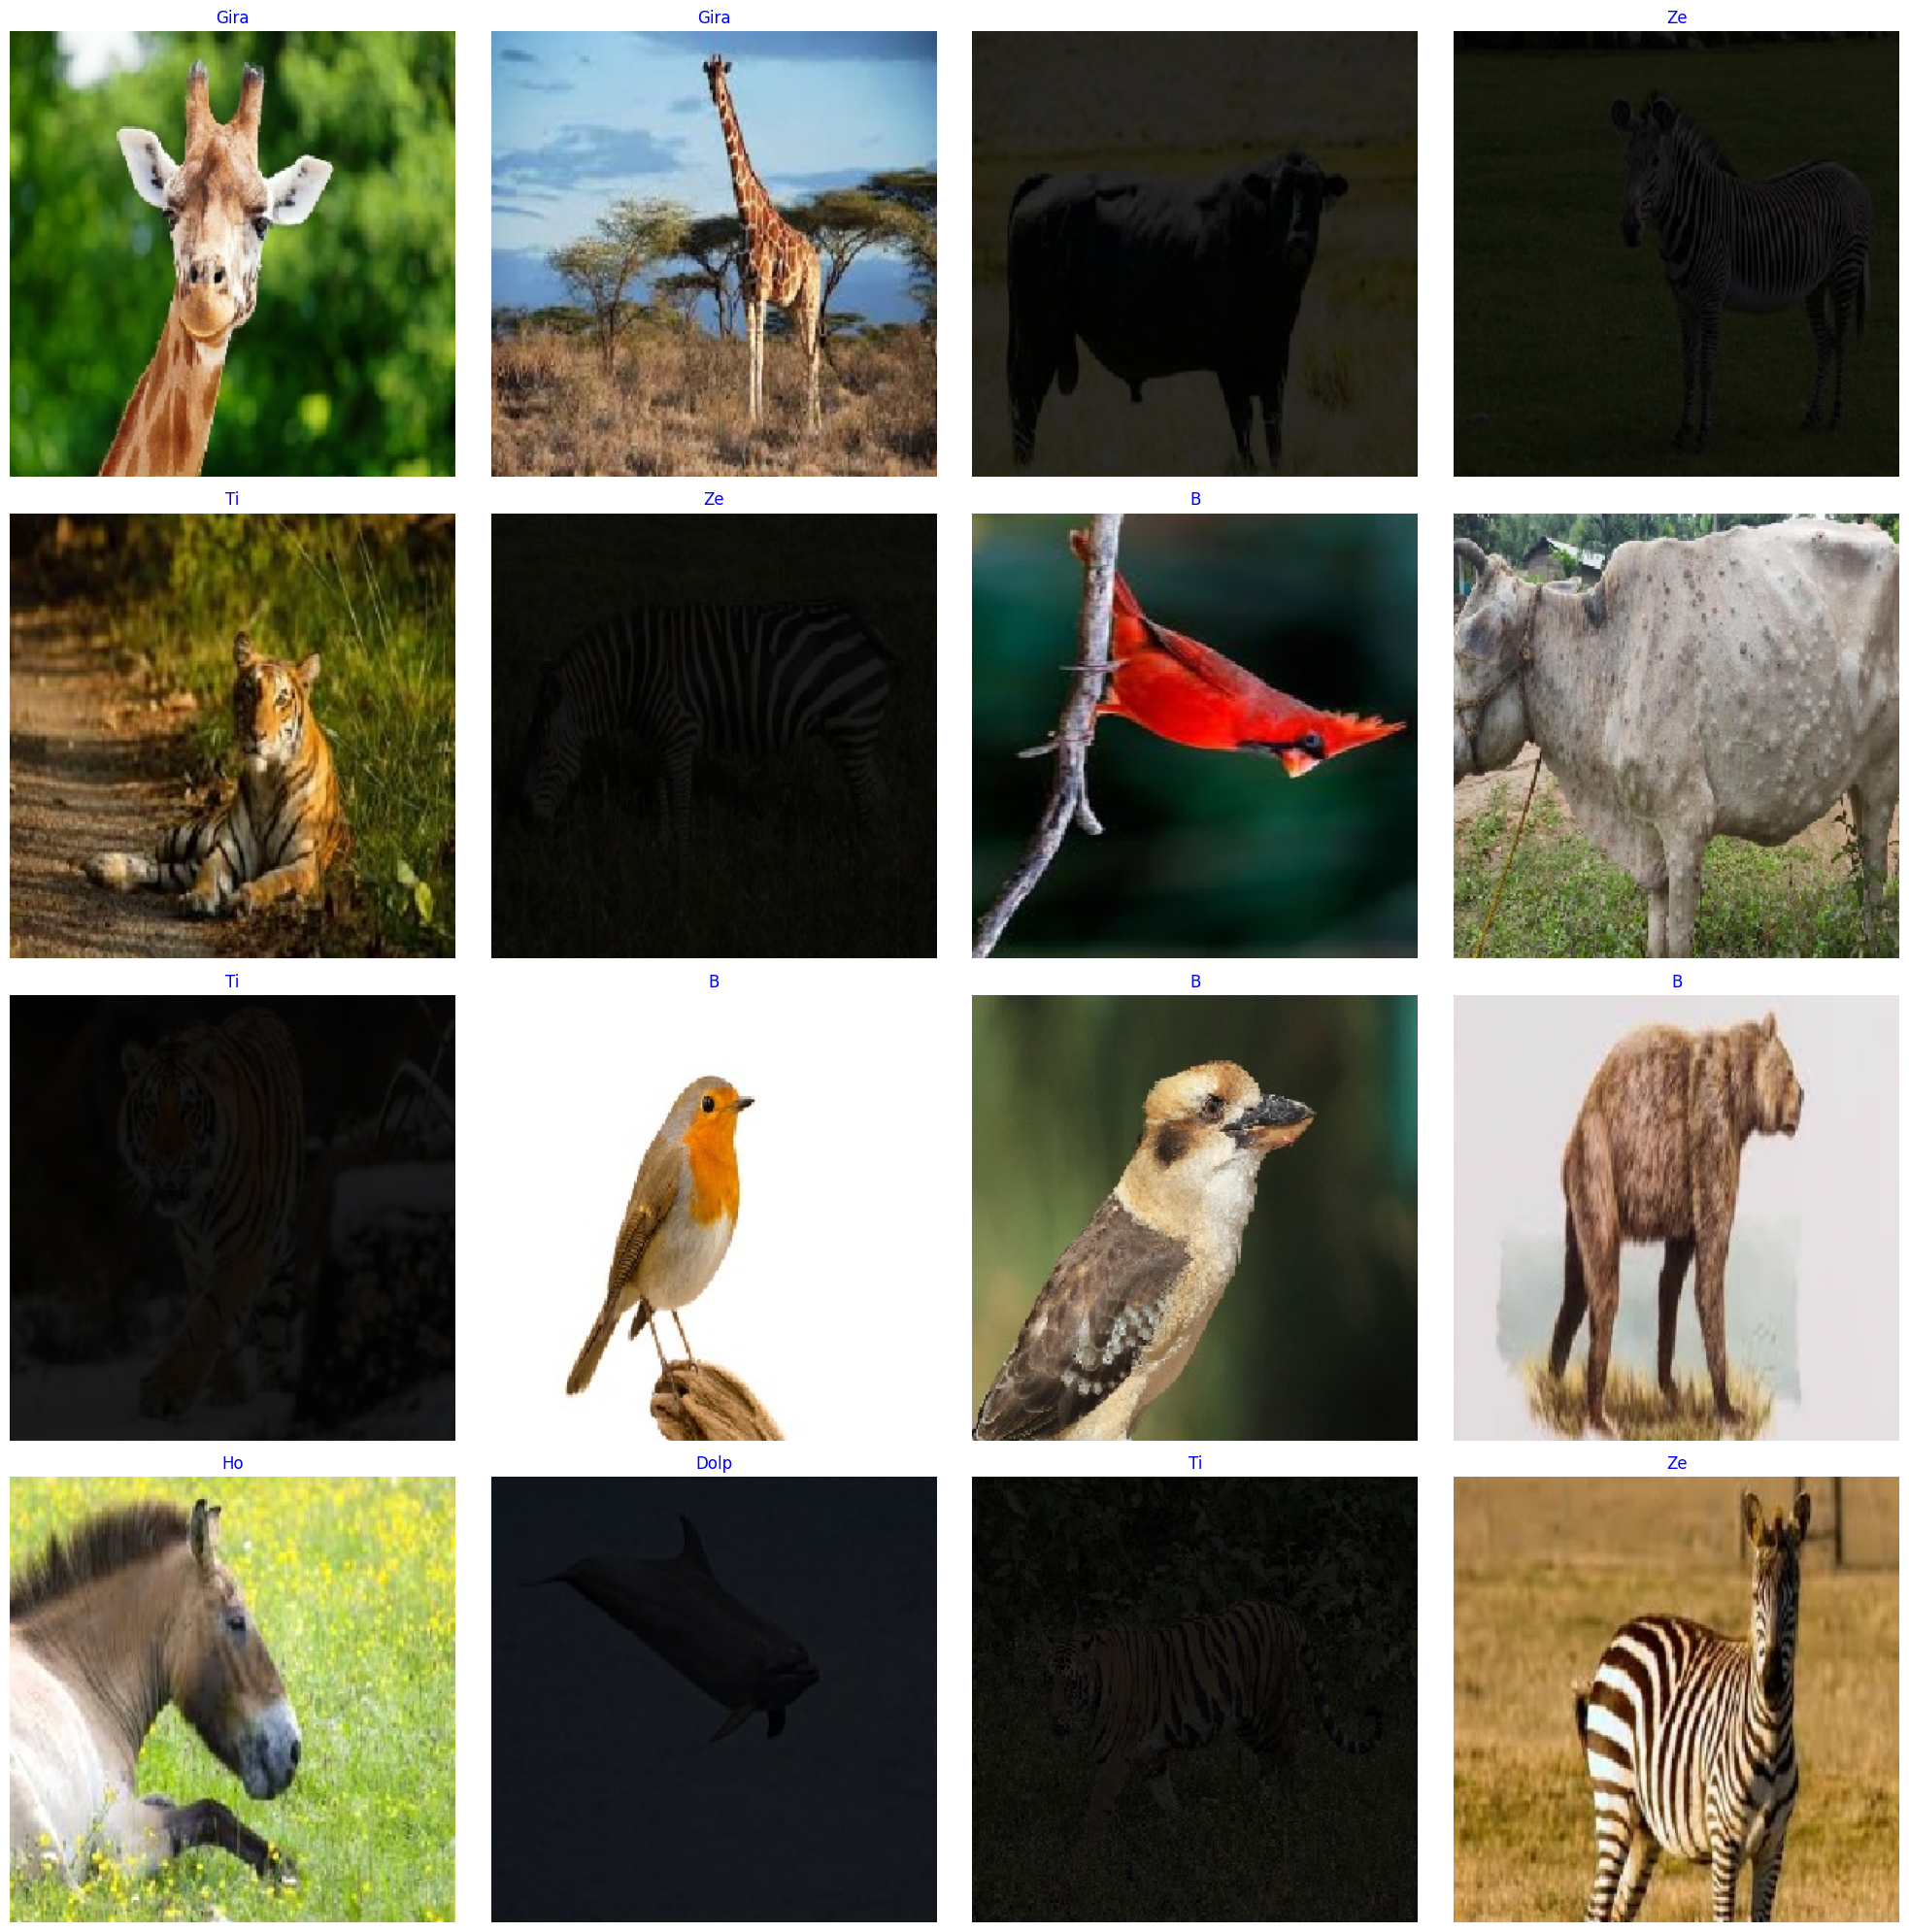

In [6]:
#Samples Of The Data
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
#Create Model Structure
from tensorflow.keras.layers import MaxPooling2D
img_size = (300, 300)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer
base_model = tf.keras.applications.VGG19(include_top= False, weights= "imagenet", input_shape= img_shape,pooling= 'max',classes=4,classifier_activation="softmax")

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation= 'relu'),
    Dropout(rate= 0.3),
    Dense(class_count, activation= 'softmax')
    
]) 

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
batch_size = 32   # set batch size for training
epochs = 5  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/5


2024-05-05 09:08:55.961820: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180000: 2.89728, expected 2.45812
2024-05-05 09:08:55.961887: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180031: 3.26032, expected 2.82116
2024-05-05 09:08:55.961896: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180045: 3.24977, expected 2.81061
2024-05-05 09:08:55.961904: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180058: 3.25872, expected 2.81956
2024-05-05 09:08:55.961912: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180073: 3.15332, expected 2.71416
2024-05-05 09:08:55.961944: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180077: 3.34182, expected 2.90266
2024-05-05 09:08:55.961956: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 180078: 3.11626, expected 2.6771
2024-05-05 09:08:55.9

97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.1193 - loss: 29.3591

2024-05-05 09:09:54.019357: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.5043, expected 3.58882
2024-05-05 09:09:54.019418: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.88461, expected 4.96914
2024-05-05 09:09:54.019428: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.88345, expected 4.96797
2024-05-05 09:09:54.019437: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.89282, expected 4.97734
2024-05-05 09:09:54.019445: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.46475, expected 5.54927
2024-05-05 09:09:54.019453: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.57721, expected 5.66173
2024-05-05 09:09:54.019462: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.24605, expected 4.33058
2024-05-05 09:09:54.019470: E external/local_xla/xla/ser

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.1194 - loss: 1076.2654

W0000 00:00:1714900206.678381     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-05-05 09:10:08.567259: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90000: 3.58967, expected 2.70128
2024-05-05 09:10:08.567322: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90001: 5.04786, expected 4.15947
2024-05-05 09:10:08.567332: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90002: 5.43206, expected 4.54367
2024-05-05 09:10:08.567340: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90003: 4.95112, expected 4.06273
2024-05-05 09:10:08.567347: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90004: 5.82464, expected 4.93625
2024-05-05 09:10:08.567355: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90005: 6.21081, expected 5.32242
2024-05-05 09:10:08.567363: E external/lo

98/98 ━━━━━━━━━━━━━━━━━━━━ 89s 486ms/step - accuracy: 0.1196 - loss: 2102.0220 - val_accuracy: 0.2146 - val_loss: 5807.8408
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.1817 - loss: 19246.6367 - val_accuracy: 0.2146 - val_loss: 18210.8887
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.1577 - loss: 105359.1016 - val_accuracy: 0.1888 - val_loss: 50342.8945
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.1163 - loss: 2208254.0000 - val_accuracy: 0.1845 - val_loss: 2672075.7500
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - accuracy: 0.0801 - loss: 461515.9375 - val_accuracy: 0.1245 - val_loss: 6470373.5000


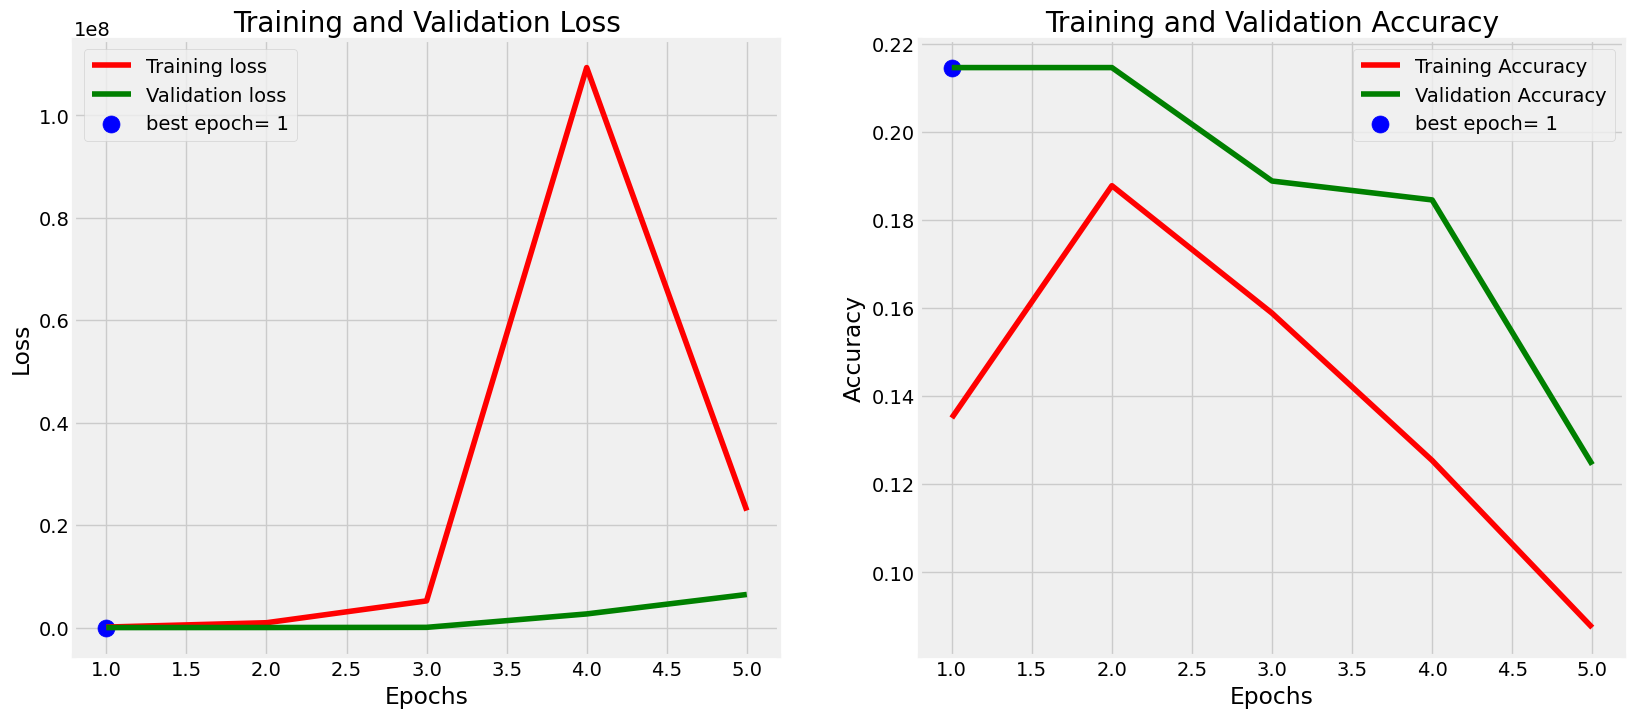

In [9]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

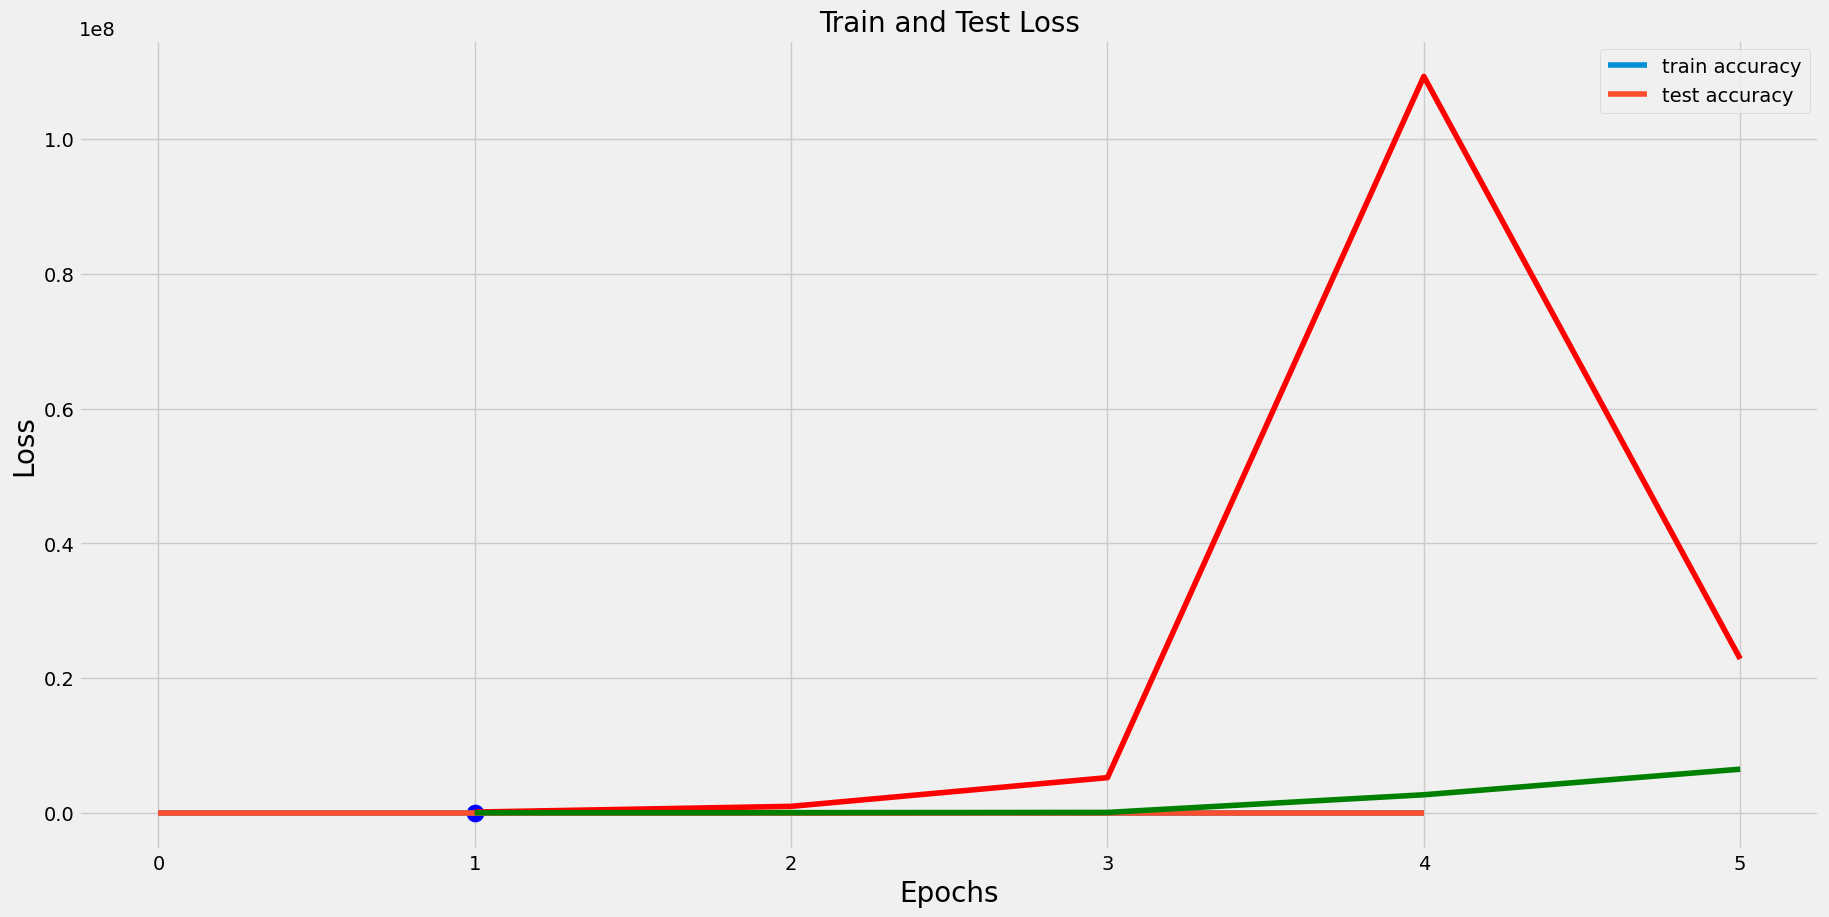

In [10]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc =  history.history['accuracy']
val_acc =  history.history['accuracy']
xc = range(len(tr_acc))

plt.figure(figsize=(20,10))
plt.plot(xc,train_acc,label='train accuracy')
plt.plot(xc,val_acc,label='test accuracy')
plt.legend()
plt.title('Train and Test Loss',size=20)
plt.xlabel('Epochs',size=20)
plt.ylabel('Loss',size=20)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.tight_layout
plt.show()

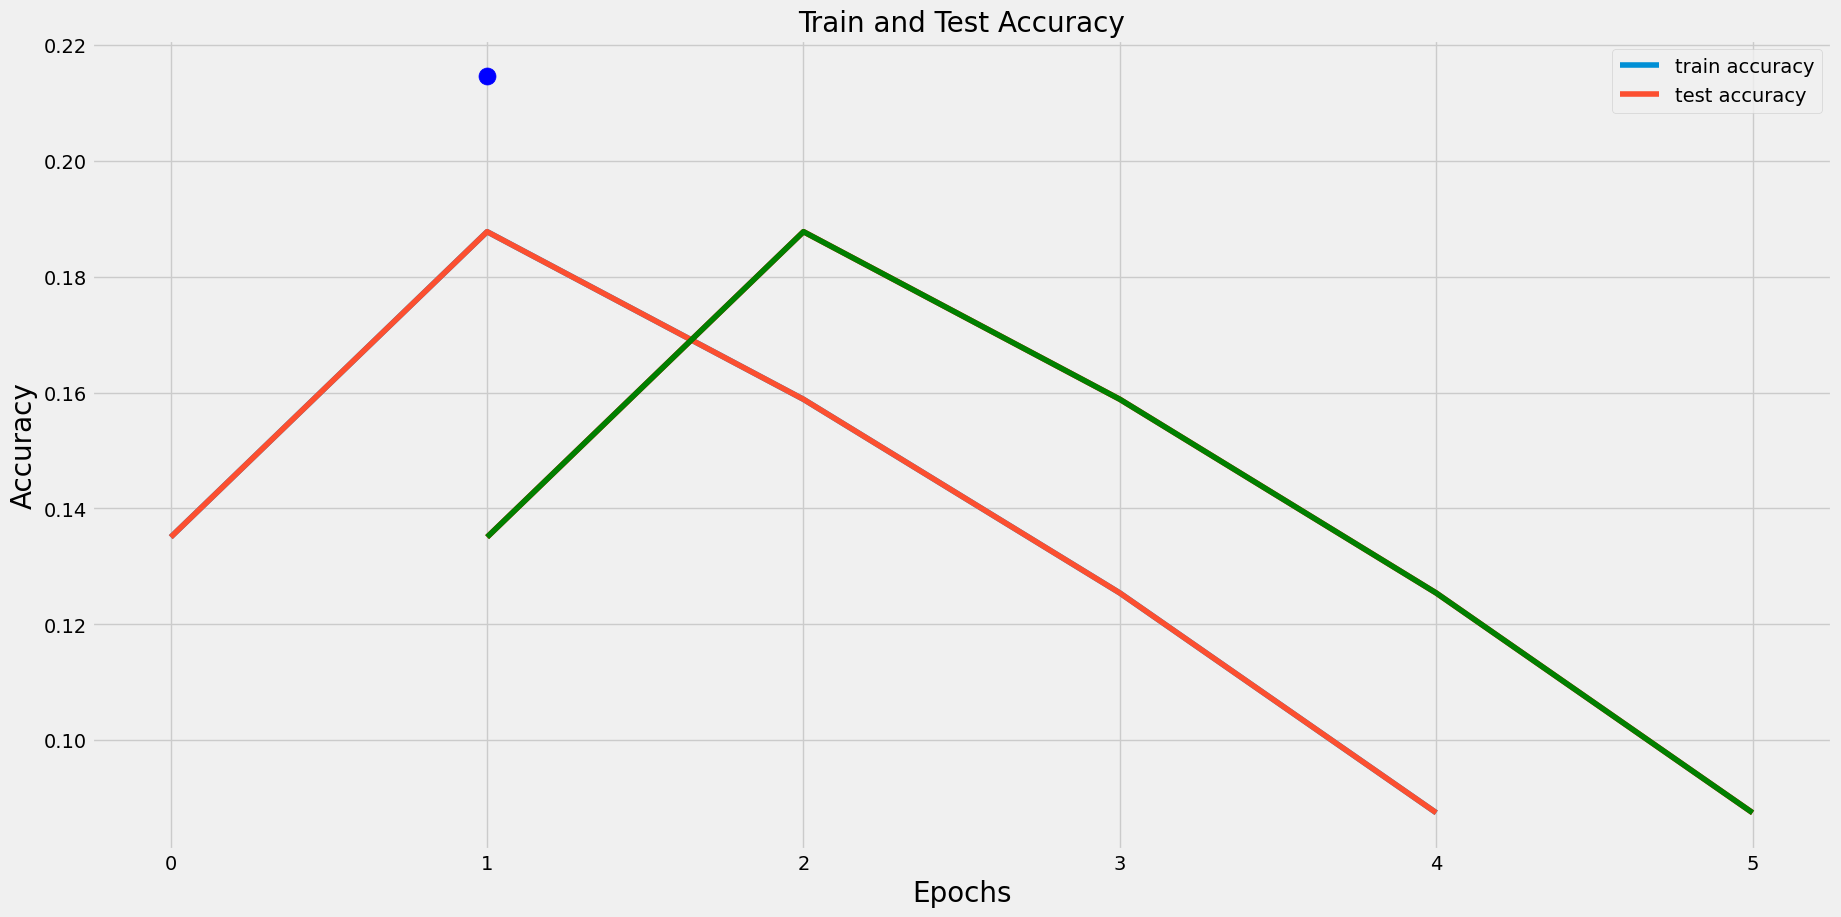

In [11]:
plt.figure(figsize=(20,10))
plt.plot(xc,train_acc,label='train accuracy')
plt.plot(xc,val_acc,label='test accuracy')
plt.legend()
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Train and Test Accuracy',size=20)
plt.xlabel('Epochs',size=20)
plt.ylabel('Accuracy',size=20)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy') 


plt.tight_layout
plt.show()

In [12]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1667 - loss: 3.5173
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1250 - loss: 3.7517
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1250 - loss: 3.5867
Train Loss:  3.824732780456543
Train Accuracy:  0.125
--------------------
Validation Loss:  3.636547327041626
Validation Accuracy:  0.15625
--------------------
Test Loss:  3.475200891494751
Test Accuracy:  0.125


In [13]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

W0000 00:00:1714900348.647183     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

2024-05-05 09:12:30.222481: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90000: 3.69373, expected 3.01354
2024-05-05 09:12:30.222538: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90002: 4.64463, expected 3.96443
2024-05-05 09:12:30.222554: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90003: 5.63678, expected 4.95658
2024-05-05 09:12:30.222572: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90005: 4.85613, expected 4.17594
2024-05-05 09:12:30.222585: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90006: 5.68428, expected 5.00409
2024-05-05 09:12:30.222596: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90007: 5.48392, expected 4.80373
2024-05-05 09:12:30.222607: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 90008: 4.93032, expected 4.25013
2024-05-05 09:12:30.222618:

10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


In [14]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

                   0.17      0.46      0.25        35
           B       0.00      0.00      0.00        25
           D       0.09      0.42      0.15        12
        Dolp       0.00      0.00      0.00         6
       Eleph       0.00      0.00      0.00        17
        Gira       0.00      0.00      0.00         7
          Ho       0.00      0.00      0.00         5
       Kanga       0.00      0.00      0.00        10
           L       0.00      0.00      0.00         9
          Pa       1.00      0.10      0.18        10
          Ti       0.00      0.00      0.00        10
          Ze       0.00      0.00      0.00        10

    accuracy                           0.14       156
   macro avg       0.11      0.08      0.05       156
weighted avg       0.11      0.14      0.08       156



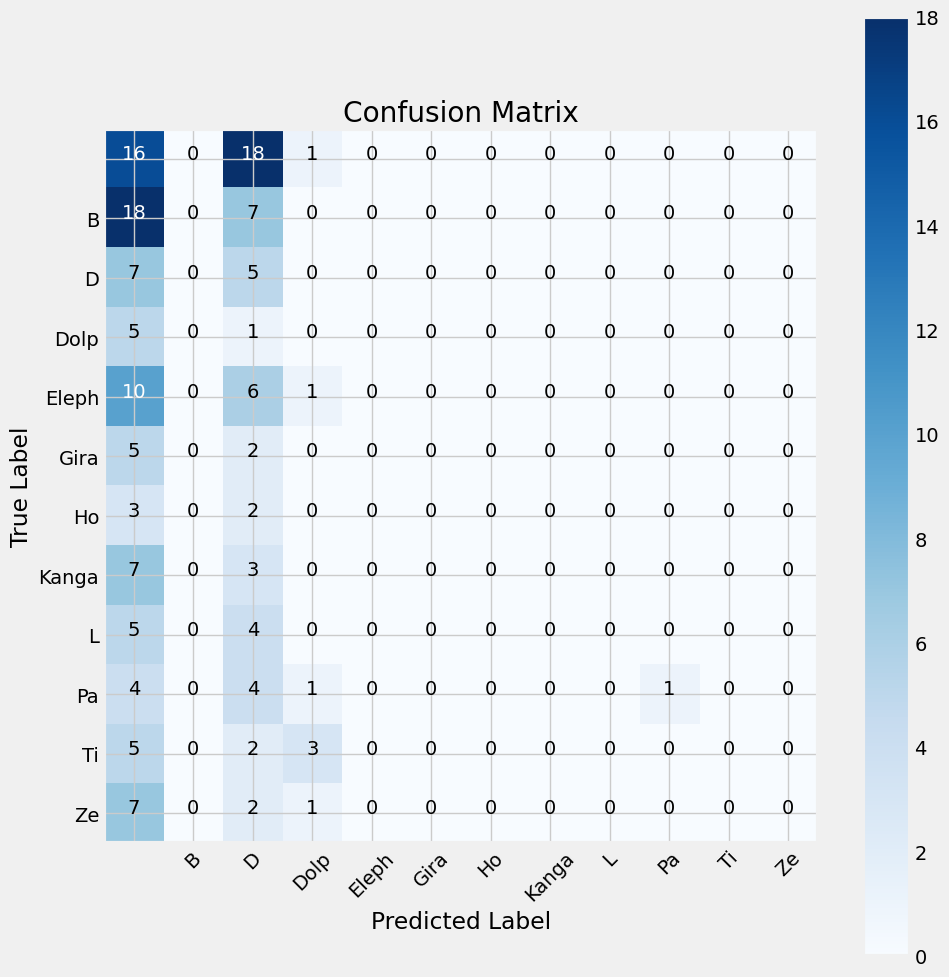

In [15]:
import itertools
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [16]:
model.save('animal_200121_EfficientNetB5_model.h5')

ValueError: Unable to synchronously create dataset (name already exists)

In [ ]:
loaded_model = tf.keras.models.load_model('animal_200121_EfficientNetB7_model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = ''
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")